In [9]:
pip install numpy scikit-learn mediapipe opencv-python matplotlib tensorflow pyarrow fastparquet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 567.9 kB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 574.4 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 KB 692.2 kB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 464.1 kB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [58]:
import os
import numpy as np
import cv2
import time
import dlib
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import fastparquet as fp
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
## Testando caminho

(-0.5, 47.5, 47.5, -0.5)

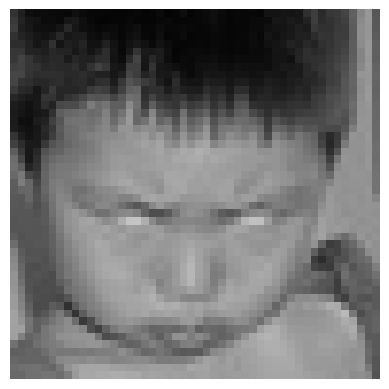

In [4]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

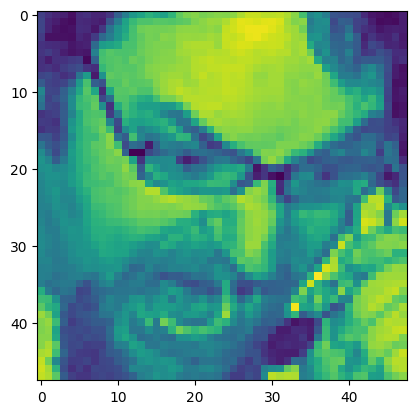

In [5]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013/archive/test/angry/PrivateTest_10131363.jpg', 0)
plt.imshow(image)

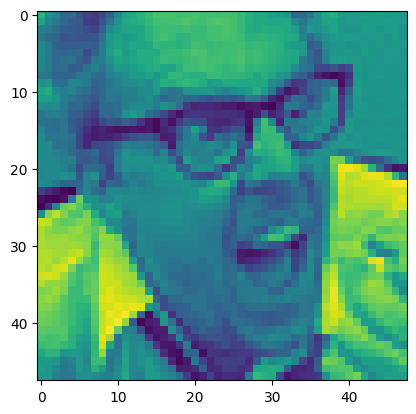

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

In [7]:
## Antes de remover as imagens

In [45]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 2 images in /home/viniciuss/Documents/projetos/FER-2013
There are 0 directories and 1 images in /home/viniciuss/Documents/projetos/FER-2013/.ipynb_checkpoints
There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train
There are 0 directories and 436 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/disgust
There are 0 directories and 4965 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/neutral
There are 0 directories and 4097 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/fear
There are 0 directories and 4830 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/sad
There are 0 directories and 3995 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/angry
There are 0 directories and 7215 images in /home/viniciuss/Documents/projetos/FER-2013/a

In [ ]:
## Depois de remover as imagens

In [51]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 2 images in /home/viniciuss/Documents/projetos/FER-2013
There are 0 directories and 1 images in /home/viniciuss/Documents/projetos/FER-2013/.ipynb_checkpoints
There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train
There are 0 directories and 385 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/disgust
There are 0 directories and 4852 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/neutral
There are 0 directories and 3763 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/fear
There are 0 directories and 4444 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/sad
There are 0 directories and 3654 images in /home/viniciuss/Documents/projetos/FER-2013/archive/train/angry
There are 0 directories and 7005 images in /home/viniciuss/Documents/projetos/FER-2013/a

In [46]:
## Iniciando

In [26]:
data_dir = '/home/viniciuss/Documents/projetos/FER-2013'

def load_images_and_labels(directory):
    images = []
    labels = []
    for label in sorted(os.listdir(directory)):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (48, 48))
                if image is not None:
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Erro ao carregar a imagem: {image_path}")
    return images, labels

train_dir = '/home/viniciuss/Documents/projetos/FER-2013/archive/train'
test_dir = '/home/viniciuss/Documents/projetos/FER-2013/archive/test'

X_train_paths, y_train_labels = load_images_and_labels(train_dir)
X_test_paths, y_test_labels = load_images_and_labels(test_dir)


In [ ]:
## Remover imagens que não são rostos

In [64]:
face_detector = mp.solutions.face_detection.FaceDetection()

for dataset in ['train', 'test']:
    dataset_dir = os.path.join(data_dir, 'archive', dataset)
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            for image_path in image_paths:
                image = cv2.imread(image_path)
                results = face_detector.process(image)
                if not results.detections:
                    os.remove(image_path)
                    print(f"Removida imagem incorreta: {image_path}")

I0000 00:00:1718893428.965786   40191 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1718893428.966720   51084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
W0000 00:00:1718893428.968378   51077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [41]:
def extract_landmarks(image):
    if image is None:
        return np.zeros(136)
    
    face_mesh = mp.solutions.face_mesh.FaceMesh()
    
    results = face_mesh.process(image)
    if results.multi_face_landmarks:
        landmarks = np.array([landmark.x for landmark in results.multi_face_landmarks[0].landmark] +
                            [landmark.y for landmark in results.multi_face_landmarks[0].landmark])
        return landmarks
    else:
        return np.zeros(136)

In [70]:
landmarks_train = []
landmarks_test = []
for image_path in X_train_paths:
    image = cv2.imread(train_dir, cv2.IMREAD_GRAYSCALE)
    landmarks = extract_landmarks(image)
    landmarks_train.append(landmarks)

for image_path in X_test_paths:
    image = cv2.imread(test_dir, cv2.IMREAD_GRAYSCALE)
    landmarks = extract_landmarks(image)
    landmarks_test.append(landmarks)

print(f"Tamanho da lista de landmarks de treinamento: {len(landmarks_train)}")
print(f"Tamanho da lista de landmarks de teste: {len(landmarks_test)}")
print(f"Tamanho dos rótulos de treinamento: {len(y_train_labels)}")
print(f"Tamanho dos rótulos de teste: {len(y_test_labels)}")

Tamanho da lista de landmarks de treinamento: 27146
Tamanho da lista de landmarks de teste: 6790
Tamanho dos rótulos de treinamento: 27146
Tamanho dos rótulos de teste: 6790


In [79]:
# Converter landmarks para arrays 1D
max_length = max(max(len(landmark) for landmark in landmarks_train), max(len(landmark) for landmark in landmarks_test))
landmarks_train = np.array([np.pad(landmark, (0, max_length - len(landmark))) for landmark in landmarks_train])
landmarks_test = np.array([np.pad(landmark, (0, max_length - len(landmark))) for landmark in landmarks_test])

# Converter rótulos para números
le = LabelEncoder()
y_train_labels = le.fit_transform(y_train_labels)
y_test_labels = le.transform(y_test_labels)

# Salvar landmarks e rótulos separadamente
np.save('X_train_landmarks.npy', landmarks_train)
np.save('X_test_landmarks.npy', landmarks_test)
np.save('y_train_labels.npy', y_train_labels)
np.save('y_test_labels.npy', y_test_labels)


In [82]:
# Ler os dados do formato Parquet
df_train = pd.read_parquet('X_train_landmarks.parquet')
df_test = pd.read_parquet('X_test_landmarks.parquet')

# Converter os dados para arrays NumPy
X_train = df_train['landmarks'].values
y_train = df_train['label'].values

X_test = df_test['landmarks'].values
y_test = df_test['label'].values

# Verificar os dados
print(f"Forma do X_train: {X_train.shape}")
print(f"Forma do y_train: {y_train.shape}")
print(f"Forma do X_test: {X_test.shape}")
print(f"Forma do y_test: {y_test.shape}")

print(f"Primeiro exemplo de X_train: {X_train[0]}")
print(f"Primeiro exemplo de y_train: {y_train[0]}")
print(f"Primeiro exemplo de X_test: {X_test[0]}")
print(f"Primeiro exemplo de y_test: {y_test[0]}")


Forma do X_train: (27146,)
Forma do y_train: (27146,)
Forma do X_test: (6790,)
Forma do y_test: (6790,)
Primeiro exemplo de X_train: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Primeiro exemplo de y_train: angry
Primeiro exemplo de X_test: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [15]:
## Modelo Radom Forest

In [83]:
# Tain model Radom Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Print Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

ValueError: setting an array element with a sequence.

In [ ]:
## Modelo SVC

In [59]:
#Model SVC
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.4784062412928392
              precision    recall  f1-score   support

       angry       0.46      0.34      0.39       958
     disgust       1.00      0.00      0.00       111
        fear       0.41      0.10      0.16      1024
       happy       0.77      0.67      0.72      1774
     neutral       0.47      0.52      0.49      1233
         sad       0.28      0.61      0.39      1247
    surprise       0.66      0.50      0.57       831

    accuracy                           0.48      7178
   macro avg       0.58      0.39      0.39      7178
weighted avg       0.53      0.48      0.47      7178



In [66]:
#Model Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100)
model.fit(X_train_scaled, y_train)

# Predição
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

ValueError: Found input variables with inconsistent numbers of samples: [27146, 28709]